In [ ]:
!pip install --upgrade gpudb==7.2.0.1 pandas pyarrow typeguard langchain langchain_openai nemollm colorlog langchain-community

### Kinetica SQLAssist context

In [4]:
import gpudb

db = gpudb.GPUdb(host='https://demo72.kinetica.com/_gpudb',
                     username='gtc',
                     password='Kinetica123!')

# We want to have our own individual context to work with, so create an extension to the context name as shown here
extension = 'amparo'

sqlcontext = f'''CREATE OR REPLACE CONTEXT nyse.nyse_vector_ctxt_{extension}
(
    TABLE = nyse.prices,
    COMMENT = 'Stock prices including ask, bid, and sale price and size',
    RULES = (
        'when I ask about stock prices, use the nyse.prices table',
        'when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day',
        'all stock symbols are in lower case',
        'when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day',
        'when I ask about any column, make sure there are no null values or NaN values',
        'replace all NaN values with 0 using the IFNAN() function',
        'all numeric results should be larger than 0',
        'convert all stock symbols to lower case',
        'always filter out null values'
    ),
    COMMENTS = (
        'ap' = 'ask price',
        'bp' = 'bid price',
        'bs' = 'bid size',
        'lp' = 'sale price',
        'ls' = 'sale size',
        's' = 'symbol',
        't' = 'timestamp'
    )
),
(
    TABLE = nyse.vector,
    COMMENT = 'Time-series vector embeddings for NYSE stock characteristics'
),
(
    SAMPLES = (
        'find all sofi stock trades between 2024-01-29 14:25:00 and 2024-01-29 14:35:00 where the price is not null' = 'SELECT t, s, lp
FROM nyse.prices
WHERE s =''sofi''
AND t BETWEEN ''2024-01-29 14:25:00'' AND ''2024-01-29 14:35:00''
AND lp IS NOT NULL;',

        'find similar patterns to sofi at 2024-01-29 14:25:00.000' = 'SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = ''2024-01-29 14:25:00.000'' and symbol = ''sofi'' limit 1))) as d1
FROM
    nyse.vector
ORDER BY
    d1 asc
LIMIT
    5;', 
        'test amparo how many rows are in the prices data?' = 'select
  count(*)
from
  nyse.prices',
  
        'show me buying opportunities for the next 15 min' = 'SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = ''2024-01-29 14:25:00.000'' and symbol = ''sofi'' limit 1))) as d1
FROM
    nyse.vector
WHERE
    ts_bkt >= now() - interval ''15'' minutes
ORDER BY
    d1 asc
LIMIT
    5;',

        'what stock symbol other than QQQ has the highest price within the last 15 minutes?' = 'SELECT
    s
FROM
    nyse.prices
WHERE
    t >= now() - interval ''15'' minutes
    and s <> ''qqq''
GROUP BY
    s
ORDER BY
    avg(lp) desc
LIMIT
    1;',
        'Show me a top 25 list of stocks from today whose value increased by at least 12%' = 'SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            lp AS current_sale_price,
            LAG(lp) OVER (PARTITION BY s ORDER BY t) AS previous_sale_price,
            (((lp - LAG(lp) OVER (PARTITION BY s ORDER BY t)) / LAG(lp) OVER (PARTITION BY s ORDER BY t)) * 100) AS price_increase_percentage
        FROM 
            nyse.prices
        WHERE
            date(t) = ''2024-01-23''
            AND lp IS NOT NULL) AS PriceChanges
WHERE
    price_increase_percentage > 12
ORDER BY
    price_increase_percentage desc
LIMIT 25'
    )
)
    '''
db.execute_sql(sqlcontext)

{'count_affected': 1,
 'response_schema_str': '{"name":"generic_response","type":"record","fields":[{"name":"column_1","type":{"type":"array","items":"string"}},{"name":"column_headers","type":{"type":"array","items":"string"}},{"name":"column_datatypes","type":{"type":"array","items":"string"}}]}',
 'binary_encoded_response': b'\x00\x02\ndummy\x00\x02\x0cstring\x00',
 'json_encoded_response': '',
 'total_number_of_records': -1,
 'has_more_records': False,
 'paging_table': '',
 'info': {'X-Kinetica-Group': 'DDL',
  'count': '0',
  'last_endpoint': '/create/context/internal',
  'total_number_of_records': '0'},
 'status_info': {'status': 'OK',
  'message': '',
  'data_type': 'execute_sql_response',
  'response_time': 0.01977},
 'record_type': kinetica.protocol.RecordType('', [('dummy', 'string')])}

### Connect to Kinetica and the LLM

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.kinetica import ChatKinetica, KineticaSqlOutputParser, KineticaSqlResponse, KineticaUtil
from IPython.display import display, HTML

# create the Kinetica connection
kdbc = KineticaUtil.create_kdbc(url="https://demo72.kinetica.com/_gpudb", user="gtc", passwd="Kinetica123!")

# create the Kinetica LLM
kinetica_llm = ChatKinetica(kdbc=kdbc)

# Set the context to use
kinetica_ctx = f'nyse.nyse_vector_ctxt_{extension}'

### Set up the context

In [6]:
# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)

================================ System Message ================================

CREATE TABLE nyse.prices AS
(
   t DATETIME NOT NULL COMMENT 'timestamp',
   s VARCHAR (8, dict, shard_key) NOT NULL COMMENT 'symbol',
   type VARCHAR (4, dict) NOT NULL,
   ap REAL  COMMENT 'ask price',
   as INTEGER,
   bp REAL  COMMENT 'bid price',
   bs INTEGER  COMMENT 'bid size',
   lp REAL  COMMENT 'sale price',
   ls INTEGER  COMMENT 'sale size'
);
COMMENT ON TABLE nyse.prices IS 'Stock prices including ask, bid, and sale price and size';
-- When querying table nyse.prices the following rules apply:
-- * when I ask about stock prices, use the nyse.prices table
-- * when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day
-- * all stock symbols are in lower case
-- * when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day
-- * when I ask about any column, make sure there are no null value

# Overview
### Setup and expectations
- Python code in the UDF folder is not intended to be run independently; it requires Kinetica to function properly
- Python code in the UDF folder is included for illustrative purposes
- Python code in the kinetica folder contains helper code and is not intended to be run independently
### Data Flow
- Data is streamed via websocket to Kinetica in JSON format
- Create delta table (just new quotes since last refresh)
- Invoke embedding model (UDF) over the delta table on every new record
- Embedding model (catch22) inserts 22 dimensional vector embedding into vector table for 5 minute windows every 5 seconds for every observed stock symbol
### Reference code
- if you want to dive deeper on the UDF that creates the vector embeddings see [./UDF/nyse_vector_embedding.py]()


In [7]:
response: KineticaSqlResponse = chain.invoke({"input": '''show me a sample of the vector data'''})
display(HTML(response.dataframe.to_html(index=False)))

ts_bkt,symbol,ap_vec
2023-06-16 17:40:00,crm,"[6.736817, 0.10749464, 1.0, 0.24475768, 222.23024, 7.628984, 0.57750195, 0.6800057, -0.60493827, 2.0, 17.0, 1.0251471, 0.083333336, 0.8125, 0.5, 0.64621705, 0.14726216, 0.055555556, 0.76957387, 2.0, 0.2375, 3.0]"
2023-06-16 17:40:00,dtm,"[0.5052257, 0.0, 1.0, 0.024246994, 51.195652, 1.8771832, 0.43434644, 0.5406227, 0.3043478, 2.0, 7.0, 0.0, 0.33333334, 0.0, 0.0, 0.15749231, 2.3561945, 1.0, 1.2141862, 2.0, 0.54545456, 4.0]"
2023-06-16 17:40:00,pba,"[1.4189638, -0.33780438, 3.0, 0.052049343, 31.282728, 0.00452267, -0.38191438, -0.49246854, 0.18181819, 2.0, 6.0, 1.0656469, 0.06666667, 0.5, 0.5, 0.4301606, 0.5890486, 0.16666667, 0.9560811, 2.0, 0.21875, 5.0]"
2023-06-16 17:40:00,virt,"[1.6243418, 0.0, 6.0, 0.052429873, 18.547209, 0.0045385025, 0.39455694, 0.5047254, -0.023255814, 2.0, 16.0, 0.0, 0.07333333, 0.64705884, 0.3529412, 0.41038948, 0.6872234, 0.25, 0.9839723, 2.0, 0.1904762, 10.0]"
2023-06-16 17:40:00,leg,"[3.403726, 0.5040576, 15.0, 0.3136487, 31.87857, 1.1480169, -0.4011887, -0.50920105, -0.23809524, 1.0, 5.0, 0.74603266, 0.18518518, 0.0, 0.0, 0.67329305, 0.19634955, 0.16666667, 0.6049901, 11.0, 0.05, 0.0]"


In [8]:
#Amparo
response: KineticaSqlResponse = chain.invoke({"input": '''find all stock symbols between 2024-01-22 13:00:00 and 2024-01-22 20:00:00 where the price is recorded that went up by more than 12%'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    s
FROM
    (
        SELECT
            s,
            lp AS current_sale_price,
            LAG(lp) OVER (PARTITION BY s ORDER BY t) AS previous_sale_price,
            (((lp - LAG(lp) OVER (PARTITION BY s ORDER BY t)) / LAG(lp) OVER (PARTITION BY s ORDER BY t)) * 100) AS price_increase_percentage
        FROM 
            nyse.prices
        WHERE
            t BETWEEN '2024-01-22 13:00:00' AND '2024-01-22 20:00:00'
            AND lp IS NOT NULL) AS PriceChanges
WHERE
    price_increase_percentage > 12;


s
cnsp
crbp
gsiw
dats
rebn
bfrgw
nm-p-h
bfrgw
octo
wnw


In [9]:
#response: SqlResponse = chain.invoke({"input": '''show me all the symbols'''})
response: KineticaSqlResponse = chain.invoke({"input": '''show me the data range'''})
#response: SqlResponse = chain.invoke({"input": '''show me data for one symbol'''})
display(HTML(response.dataframe.to_html(index=False)))

EXPR_0,EXPR_1
2023-06-16 17:44:03.198,2024-02-27 18:43:32.896


In [10]:
response: KineticaSqlResponse = chain.invoke({"input": '''what is the total number of rows?'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    count(*) AS total_rows
FROM
    nyse.prices
LIMIT
    1;


total_rows
3484683646


In [11]:
#this use to work before but not anymore
response: KineticaSqlResponse = chain.invoke({"input": '''how many rows are in the prices table with value lower than average?'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    count(*)
FROM
    nyse.prices
WHERE
    lp < (SELECT avg(lp) FROM nyse.prices);


EXPR_0
164413541


### Some questions, including vector similarity search, without the SQL fuss

In [13]:
# Here you must ask a question relevant to the LLM context provided in the prompt template.
#response: SqlResponse = chain.invoke({"input": '''what stock has traded with the highest volume today?'''})
#response: SqlResponse = chain.invoke({"input": '''what stock has traded with the highest average today?'''})
response: KineticaSqlResponse = chain.invoke({"input": '''what was the average price for tsla yesterday?'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    avg(lp)
FROM
    nyse.prices
WHERE
    s = 'tsla'
    AND date(t) = '2024-01-23';


EXPR_0
210.404255


In [14]:
response: KineticaSqlResponse = chain.invoke({"input": '''Show me a top 10 list of stocks from today whose value increased by at least 12%'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            lp AS current_sale_price,
            LAG(lp) OVER (PARTITION BY s ORDER BY t) AS previous_sale_price,
            (((lp - LAG(lp) OVER (PARTITION BY s ORDER BY t)) / LAG(lp) OVER (PARTITION BY s ORDER BY t)) * 100) AS price_increase_percentage
        FROM 
            nyse.prices
        WHERE
            date(t) = '2024-01-23'
            AND lp IS NOT NULL) AS PriceChanges
WHERE
    price_increase_percentage > 12
ORDER BY
    price_increase_percentage desc
LIMIT 10


s,price_increase_percentage
evax,71.461189
zjyl,64.458687
zvzzt,40.467594
cslmw,36.827595
rvsnw,29.999992
fazew,28.476822
winvr,28.241566
dtss,25.641033
cslmr,23.478262
nuwe,22.290388


<Axes: xlabel='t'>

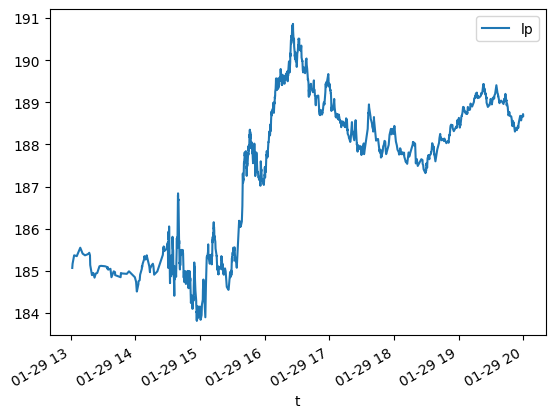

In [15]:
response: KineticaSqlResponse = chain.invoke({"input": '''find all tsla stock trades between 2024-01-29 13:00:00 and 2024-01-29 20:00:00 where the price is recorded'''})
response.dataframe.plot.line(x='t', y='lp')

In [16]:
response: KineticaSqlResponse = chain.invoke({"input": '''find similar patterns to sofi at 2024-01-29 14:25:00.000'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol ='sofi' limit 1))) as d1
FROM
    nyse.vector
ORDER BY
    d1 asc
LIMIT
    5;


ts_bkt,symbol,d1
2023-06-28 16:00:00,alny,-365788.0625
2023-06-27 13:30:00,tqqq,-356100.875
2023-12-20 19:50:00,qqq,-322043.28125
2023-06-22 13:35:00,tqqq,-309997.6875
2023-07-13 13:30:00,tqqq,-307590.6875


SELECT t, s, lp
FROM nyse.prices
WHERE s ='tqqq'
AND t BETWEEN '2023-07-07 14:30:00' AND '2023-07-07 14:40:00'
AND lp IS NOT NULL;


<Axes: xlabel='t'>

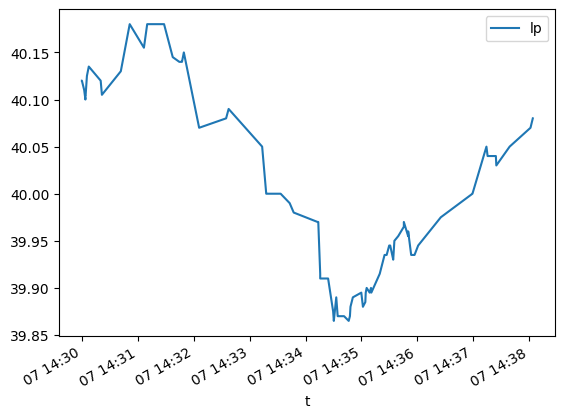

In [17]:
response: KineticaSqlResponse = chain.invoke({"input": '''find all tqqq stock trades between 2023-07-07 14:30:00 and 2023-07-07 14:40:00 where the price is recorded'''})
print(response.sql)
response.dataframe.plot.line(x='t', y='lp')

### Get Kinetica LLM and Nemo talking to each other
- Helper code is in [./kinetica/kineai.py]() and can be referenced to understand how the two LLM's are connected to each other
- The intent with this exercise is to create a "Man in the Middle" RAG that provides us with the best features of two different LLM's, one for generating accurate SQL, then other to carry on a conversation and summarize tabular result sets when appropriate

In [25]:
import importlib
import kinetica.kineai

importlib.reload(kinetica.kineai)
kineticallm = kinetica.kineai.KineticaLLM(f'nyse.nyse_vector_ctxt_{extension}')

INFO:SqlAssistLLM:Connected to http://172.31.33.30:9191. (version 7.2.0.1)


### The Nemo context object
- This is how we adjust how the LLM will react to our specific situation.
- Many samples are provided so that Nemo will be able to take in plain english, pass it to Kinetica's LLM, then summarize the results
- Note that small changes can have large effects.
- Feel free to experiment with this context to see what the effects are

In [19]:
system = """ KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica
LLM is designed to translate natural language questions into SQL queries. 

In addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. 
If it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer 
to the question in JSON format to the question made to SqlAssist by KineticAI.

when presented with a question, you should prefix your response with "KineticaLLM | "
if a sentence ends in a "?", you should prefix your response with "KineticaLLM | "

Consider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from 
SqlAssist to answer the user's question.

user: KineticaLLM | [{"EXPR_0": 5.4}]
assistant: The answer is 5.4
"""
#firt 4 pair hwo to call Kinetika (this )
# Ilustrate this better where you have a bigger paragraph
# Have the content asnwer. 
context0 = [dict(role="system", content=system),
            dict(role="user", content='KineticaLLM | [{"EXPR_0": 5.4}]'),
            dict(role="assistant", content='The answer is 5.4'),
            dict(role="user", content='KineticaLLM | [{"ts_bkt": "2024-02-07 19:35:00.000", "symbol": "aapl", "d1": -6467.2607421875}, {"ts_bkt": "2024-02-07 19:30:00.000", "symbol": "aapl", "d1": -6406.75341796875}, {"ts_bkt": "2024-02-07 19:45:00.000", "symbol": "tsla", "d1": -6331.88671875}, {"ts_bkt": "2024-02-07 19:40:00.000", "symbol": "tsla", "d1": -6128.375}]'),
            dict(role="assistant", content='It looks like aapl and tsla might be good choices'),
            dict(role='user', content='KineticaLLM |  [{"s": "nvr"}]'),
            dict(role='assistant', content='It looks like NVR might be a good choice')]

In [20]:
question = 'what stock symbol other than Apple has the highest price within the last 15 hours?'
response = kineticallm.chat(context0, question)

INFO:NemoChatLLM:user: KineticaLLM |  [{"s": "nvr"}] (tokens: 879/3217)
INFO:NemoChatLLM:assistant: It looks like NVR might be a good choice (tokens: 962/3134)


In [21]:
question = 'find potential buying opportunities over the next 12 hours?'
response = kineticallm.chat(context0, question)

INFO:SqlAssistLLM:Query: find potential buying opportunities over the next 12 hours?
INFO:SqlAssistLLM:SQL: SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol ='sofi' limit 1))) as d1
FROM
    nyse.vector
WHERE
    ts_bkt >= now() - interval '12' hours
ORDER BY
    d1 asc
LIMIT
    5;
INFO:NemoChatLLM:user: KineticaLLM |  [{"ts_bkt": "2024-02-27 15:15:00.000", "symbol": "qqq", "d1": -9383.5732421875}, {"ts_bkt": "2024-02-27 15:20:00.000", "symbol": "qqq", "d1": -9164.275390625}, {"ts_bkt": "2024-02-27 15:55:00.000", "symbol": "qqq", "d1": -8013.435546875}, {"ts_bkt": "2024-02-27 17:50:00.000", "symbol": "qqq", "d1": -7994.7890625}, {"ts_bkt": "2024-02-27 18:05:00.000", "symbol": "qqq", "d1": -7989.6640625}] (tokens: 1159/2937)
INFO:NemoChatLLM:assistant: It looks like qqq might be a good choice (tokens: 1242/2854)


In [22]:
chainsql = prompt_template | kinetica_llm

In [23]:
response: KineticaSqlResponse = chainsql.invoke({"input": '''find all tqqq stock trades between 2023-07-07 14:30:00 and 2023-07-07 14:40:00 where the price is recorded'''})
print(response.content)

SELECT t, s, lp
FROM nyse.prices
WHERE s ='tqqq'
AND t BETWEEN '2023-07-07 14:30:00' AND '2023-07-07 14:40:00'
AND lp IS NOT NULL;
